# ResNet-18: AdamW + CIFAR10 + albumentations

In [1]:
# Specify GPU to be used-
%env CUDA_DEVICE_ORDER = PCI_BUS_ID
'''
Specify GPU(s) to be used here. Say you have 6 GPUs and you want to train Model A on 2 of them
and Model B on 4 of them. You can do that as follows-
CUDA_VISIBLE_DEVICES=0,1 python model_A.py
CUDA_VISIBLE_DEVICES=2,3,4,5 python model_B.py
'''
# %env CUDA_VISIBLE_DEVICES = 0, 1, 2, 3
%env CUDA_VISIBLE_DEVICES = 0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
# import torchvision.transforms as transforms

from tqdm import tqdm
from tqdm import trange
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os, pickle
import albumentations as A
from albumentations.pytorch import ToTensorV2

C:\Users\arjun\anaconda3\envs\torch-cuda\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
print(f"torch version: {torch.__version__}")

# Check if there are multiple devices (i.e., GPU cards)-
print(f"Number of GPU(s) available = {torch.cuda.device_count()}")

# Which GPU Is The Current GPU?
# print(f"current GPU: {torch.cuda.current_device()}")

# Get the name of the current GPU-
# print(f"Current GPU name: {torch.cuda.get_device_name(torch.cuda.current_device())}")

# Is PyTorch using a GPU?
# print(f"Is PyTorch using a GPU? {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"Current GPU: {torch.cuda.current_device()}")
    print(f"Current GPU name: {torch.cuda.get_device_name(torch.cuda.current_device())}")
else:
    print("PyTorch does not have access to GPU")

torch version: 1.13.1
Number of GPU(s) available = 1
Current GPU: 0
Current GPU name: NVIDIA GeForce RTX 3080 Laptop GPU


In [4]:
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |
|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |
|---------------------------------------------------------------------------|
| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |

In [5]:
# Device configuration-
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Available device is {device}')

Available device is cuda


In [6]:
# Specify hyper-parameters
batch_size = 256
num_classes = 10
num_epochs = 80

In [7]:
# Define transformations using albumentations-
transform_train = A.Compose(
    [
        # A.Resize(width = 32, height = 32),
        # A.RandomCrop(width = 20, height = 20),
        A.Rotate(limit = 40, p = 0.9, border_mode = cv2.BORDER_CONSTANT),
        A.HorizontalFlip(p = 0.5),
        A.VerticalFlip(p = 0.1),
        A.RGBShift(r_shift_limit = 25, g_shift_limit = 25, b_shift_limit = 25, p = 0.9),
        A.OneOf([
            A.Blur(blur_limit = 3, p = 0.5),
            A.ColorJitter(p = 0.5),
        ], p = 1.0),
        A.Normalize(
            # mean = [0.4914, 0.4822, 0.4465],
            # std = [0.247, 0.243, 0.261],
            mean = [0, 0, 0],
            std = [1, 1, 1],
            max_pixel_value = 255,
        ),
        # This is not dividing by 255, which it does in PyTorch-
        ToTensorV2(),
    ]
)

transform_val = A.Compose(
    [
        A.Normalize(
            mean = [0, 0, 0],
            std = [1, 1, 1],
            max_pixel_value = 255
        ),
        ToTensorV2()
    ]
)


In [8]:
class Cifar10Dataset(torchvision.datasets.CIFAR10):
    def __init__(
        self, root = "~/data/cifar10",
        train = True, download = True,
        transform = None
    ):
        super().__init__(
            root = root, train = train,
            download = download, transform = transform
        )

    def __getitem__(self, index):
        image, label = self.data[index], self.targets[index]

        if self.transform is not None:
            transformed = self.transform(image = image)
            image = transformed["image"]

        return image, label


In [9]:
# Define train and validate sets-
train_dataset = Cifar10Dataset(
    root = 'C:/Users/arjun/Downloads/data/', train = True,
    download = True, transform = transform_train
)

val_dataset = Cifar10Dataset(
    root = 'C:/Users/arjun/Downloads/data/', train = False,
    download = True, transform = transform_val
)

Files already downloaded and verified
Files already downloaded and verified


In [10]:
# Define train and validate loaders-
train_loader = torch.utils.data.DataLoader(
    dataset = train_dataset, batch_size = batch_size,
    shuffle = True
    )

val_loader = torch.utils.data.DataLoader(
    dataset = val_dataset, batch_size = batch_size,
    shuffle = True
    )

In [11]:
print(f"len(train_dataset) = {len(train_dataset)} & len(val_dataset) = {len(val_dataset)}")
print(f"len(train_loader) = {len(train_loader)} & len(val_loader) = {len(val_loader)}")

len(train_dataset) = 50000 & len(val_dataset) = 10000
len(train_loader) = 196 & len(val_loader) = 40


In [12]:
# Sanity check-
len(train_dataset) / batch_size, len(val_dataset) / batch_size

(195.3125, 39.0625)

In [13]:
class ResNet_Block(nn.Module):
    '''
    Residual block for a ResNet CNN model
    '''
    def __init__(
        self, num_inp_channels,
        num_channels, stride = 1,
        dropout = 0.2, use_1x1_conv = False
    ):
        super(ResNet_Block, self).__init__()
        
        self.num_inp_channels = num_inp_channels
        self.num_channels = num_channels
        self.stride = stride
        self.dropout = dropout
        self.use_1x1_conv = use_1x1_conv
    
        
        self.conv1 = nn.Conv2d(
            in_channels = self.num_inp_channels, out_channels = self.num_channels,
            kernel_size = 3, padding = 1,
            stride = self.stride, bias = False
        )
        self.bn1 = nn.BatchNorm2d(num_features = self.num_channels)
        
        self.conv2 = nn.Conv2d(
            in_channels = self.num_channels, out_channels = self.num_channels,
            kernel_size = 3, padding = 1,
            stride = 1, bias = False
        )
        self.bn2 = nn.BatchNorm2d(num_features = self.num_channels)
        self.dropout = nn.Dropout(p = self.dropout)
        
        if self.use_1x1_conv:
            self.conv3 = nn.Conv2d(
            in_channels = self.num_inp_channels, out_channels = num_channels,
            kernel_size = 1, padding = 0,
            stride = self.stride, bias = False
            )
            self.bn3 = nn.BatchNorm2d(num_features = self.num_channels)
        
        self.initialize_weights()

            
    def initialize_weights(self):
        for m in self.modules():
            # print(m)
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)

                '''
                # Do not initialize bias (due to batchnorm)-
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
                '''
            
            elif isinstance(m, nn.BatchNorm2d):
                # Standard initialization for batch normalization-
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    
    def forward(self, x):
        y = F.leaky_relu(self.bn1(self.conv1(x)))
        y = self.dropout(F.leaky_relu(self.bn2(self.conv2(y))))
        
        if self.use_1x1_conv:
            x = self.bn3(self.conv3(x))
            
        y += x
        return F.leaky_relu(self.dropout(y))
    
    
    def shape_computation(self, x):
        print(f"Input shape: {x.shape}")
        y = (self.bn1(self.conv1(x)))
        print(f"First conv layer output shape: {y.shape}")
        y = self.bn2(self.conv2(y))
        print(f"Second conv layer output shape: {y.shape}")
        
        if self.use_1x1_conv:
            x = self.bn3(self.conv3(x))
            print(f"Downsample with S = 2; identity connection output shape: {x.shape}")
            
        y += x
        print(f"Residual block output shape: {y.shape}")
        return None
    

In [14]:
class ResNet18(nn.Module):
    def __init__(self):
        super(ResNet18, self).__init__()
        
        self.conv1 = nn.Conv2d(
            in_channels = 3, out_channels = 64,
            kernel_size = 3, padding = 1,
            stride = 1, bias = False
        )
        self.bn1 = nn.BatchNorm2d(num_features = 64)
        
        self.resblock1 = ResNet_Block(
            num_inp_channels = 64, num_channels = 64,
            stride = 1, dropout = 0.2,
            use_1x1_conv = False
        )
        
        self.resblock2 = ResNet_Block(
            num_inp_channels = 64, num_channels = 64,
            stride = 1, dropout = 0.2,
            use_1x1_conv = False
        )
        
        # Downsample-
        self.resblock3 = ResNet_Block(
            num_inp_channels = 64, num_channels = 128,
            stride = 2, dropout = 0.2,
            use_1x1_conv = True
        )
        
        self.resblock4 = ResNet_Block(
            num_inp_channels = 128, num_channels = 128,
            stride = 1, dropout = 0.2,
            use_1x1_conv = False
        )

        # Downsample-
        self.resblock5 = ResNet_Block(
            num_inp_channels = 128, num_channels = 256,
            stride = 2, dropout = 0.2,
            use_1x1_conv = True
        )

        self.resblock6 = ResNet_Block(
            num_inp_channels = 256, num_channels = 256,
            stride = 1, dropout = 0.2,
            use_1x1_conv = False
        )

        # Downsample-
        self.resblock7 = ResNet_Block(
            num_inp_channels = 256, num_channels = 512,
            stride = 2, dropout = 0.2,
            use_1x1_conv = True
        )

        self.resblock8 = ResNet_Block(
            num_inp_channels = 512, num_channels = 512,
            stride = 1, dropout = 0.2,
            use_1x1_conv = False
        )
        
        self.avg_pool = nn.AvgPool2d(kernel_size = 3, stride = 2)
        self.op_layer = nn.Linear(
            in_features = 512, out_features = 10,
            bias = True
        )
        
    
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.resblock1(x)
        x = self.resblock2(x)
        x = self.resblock3(x)
        x = self.resblock4(x)
        x = self.resblock5(x)
        x = self.resblock6(x)
        x = self.resblock7(x)
        x = self.resblock8(x)
        x = self.avg_pool(x).squeeze()
        x = self.op_layer(x)
        return x
    

In [15]:
# Initialize ResNet-18 architecture-
model = ResNet18().to(device)

In [17]:
# Count number of layer-wise parameters and total parameters-
tot_params = 0
for param in model.parameters():
    # print(f"layer.shape = {param.shape} has {param.nelement()} parameters")
    tot_params += param.nelement()

In [18]:
print(f"Total number of parameters in ResNet-18 CNN = {tot_params}")

Total number of parameters in ResNet-18 CNN = 11173962


In [19]:
# Save random initial weights-
torch.save(model.state_dict(), 'ResNet18_random_weights.pth')

# Load randomly initialised weights-
# model.load_state_dict(torch.load('VGG18_random_weights_dropouts.pth'))

In [20]:
# Define loss function and optimizer-
loss = nn.CrossEntropyLoss()

# optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
# optimizer = torch.optim.SGD(model.parameters(), lr = 0.0, momentum = 0.9, weight_decay = 5e-4)
optimizer = torch.optim.AdamW(
    params = model.parameters(), lr = 0.0,
    betas = (0.9, 0.999), eps = 1e-08,
    weight_decay = 5e-4, amsgrad = True
)

### Train model with learning rate scheduler

Training dataset = 50000, batch size = 256, number of training steps/iterations per epoch = 50000 / 256 = 195.3125 = 195

After an initial linear learning rate warmup of 13 epochs or 2539 training steps:

- For the next 32 epochs, or, 6250 steps - until 43rd epoch, use lr = 0.1.

- For the next 25 epochs, or, 4882 steps - until 68th epoch, use lr = 0.01.

- For remaining epochs (13 epochs), use lr = 0.001.

In [21]:
boundaries = [6250, 11132]
values = [0.1, 0.01, 0.001]

In [22]:
def decay_function(step, boundaries = [6250, 11132], values = [0.1, 0.01, 0.001]):
    
    for idx, bound in enumerate(boundaries):
        if step < bound:
            return values[idx]

    return values[-1]


In [23]:
class schedule():

    def __init__(self, initial_learning_rate = 0.1, warmup_steps = 1000, decay_func = None):
        self.initial_learning_rate = initial_learning_rate
        self.warmup_steps = warmup_steps
        self.decay_func = decay_func
        self.warmup_step_size = initial_learning_rate/warmup_steps
        self.current_lr = 0

    def get_lr(self, step):
        if step == 0:
            return self.current_lr
        elif step <= self.warmup_steps:
            self.current_lr+=self.warmup_step_size
            return self.current_lr
        elif step > self.warmup_steps:
            if self.decay_func:
                return self.decay_func(step)
        else:
            return self.current_lr
        

In [24]:
# Initial linear LR warmup: 195.3125 x 13 = 2549 steps in 13 epochs.
custom_lr_scheduler = schedule(
    initial_learning_rate = 0.1, warmup_steps = 2539,
    decay_func = decay_function
)

In [25]:
step = 0

In [26]:
def train_model_progress(model, train_loader, train_dataset):
    '''
    Function to perform one epoch of training by using 'train_loader'.
    Returns loss and number of correct predictions for this epoch.
    '''
    running_loss = 0.0
    running_corrects = 0.0
    
    model.train()
    
    with tqdm(train_loader, unit = 'batch') as tepoch:
        for images, labels in tepoch:
            tepoch.set_description(f"Training: ")
            
            images = images.to(device)
            labels = labels.to(device)
            
            # Get model predictions-
            outputs = model(images)
            
            # Compute loss-
            J = loss(outputs, labels)
            
            # Empty accumulated gradients-
            optimizer.zero_grad()
            
            # Perform backprop-
            J.backward()
            
            # Update parameters-
            optimizer.step()
            
            global step
            optimizer.param_groups[0]['lr'] = custom_lr_scheduler.get_lr(step)

            step += 1
            
            # Compute model's performance statistics-
            running_loss += J.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            running_corrects += torch.sum(predicted == labels.data)
            
            tepoch.set_postfix(
                loss = running_loss / len(train_dataset),
                accuracy = (running_corrects.double().cpu().numpy() / len(train_dataset)) * 100
            )
            
    
    train_loss = running_loss / len(train_dataset)
    train_acc = (running_corrects.double() / len(train_dataset)) * 100
    

    # return running_loss, running_corrects
    return train_loss, train_acc.cpu().numpy()

def test_model_progress(model, test_loader, test_dataset):
    total = 0.0
    correct = 0.0
    running_loss_val = 0.0

    with torch.no_grad():
        with tqdm(test_loader, unit = 'batch') as tepoch:
            for images, labels in tepoch:
                tepoch.set_description(f"Validation: ")
                
                images = images.to(device)
                labels = labels.to(device)
                
                # Set model to evaluation mode-
                model.eval()
            
                # Predict using trained model-
                outputs = model(images)
                _, y_pred = torch.max(outputs, 1)
                
                # Compute validation loss-
                J_val = loss(outputs, labels)
                
                running_loss_val += J_val.item() * labels.size(0)
    
                # Total number of labels-
                total += labels.size(0)

                # Total number of correct predictions-
                correct += (y_pred == labels).sum()
                
                tepoch.set_postfix(
                    val_loss = running_loss_val / len(test_dataset),
                    val_acc = 100 * (correct.cpu().numpy() / total)
                )
            
        
    # return (running_loss_val, correct, total)
    val_loss = running_loss_val / len(test_dataset)
    val_acc = (correct / total) * 100

    return val_loss, val_acc.cpu().numpy()


In [28]:
# Python3 dict to contain training metrics-
training_history_lr_scheduler = {}

# Initialize parameters saving 'best' models-
best_val_acc = 50

In [29]:
for epoch in range(num_epochs):

    # Train and validate model for 1 epoch-
    train_loss, train_acc = train_model_progress(
        model = model, train_loader = train_loader,
        train_dataset = train_dataset
    )
    val_loss, val_acc = test_model_progress(
        model = model, test_loader = val_loader,
        test_dataset = val_dataset
    )
    
    print(f"\nepoch: {epoch + 1} training loss = {train_loss:.4f}, "
          f"training accuracy = {train_acc:.2f}%, val_loss = {val_loss:.4f}"
          f", val_accuracy = {val_acc:.2f}% & "
          f"LR = {optimizer.param_groups[0]['lr']:.4f}\n")
    
    training_history_lr_scheduler[epoch + 1] = {
        'loss': train_loss, 'acc': train_acc,
        'val_loss': val_loss, 'val_acc': val_acc,
        'lr': optimizer.param_groups[0]['lr']
    }

    
    # Save best weights achieved until now-
    if (val_acc > best_val_acc):
        # update 'best_val_loss' variable to lowest loss encountered so far-
        best_val_acc = val_acc

        print(f"Saving model with highest val acc = {val_acc:.3f}%\n")
        
        # Save trained model with 'best' validation accuracy-
        torch.save(model.state_dict(), "ResNet18_best_valacc_model.pth")
        

Validation: : 100%|██████████████████████████████████████| 40/40 [00:01<00:00, 21.65batch/s, val_acc=37, val_loss=1.87]



epoch: 1 training loss = 1.9528, training accuracy = 28.21%, val_loss = 1.8749, val_accuracy = 37.03% & LR = 0.0077



Validation: : 100%|██████████████████████████████████████| 40/40 [00:01<00:00, 21.59batch/s, val_acc=56, val_loss=1.24]



epoch: 2 training loss = 1.6018, training accuracy = 42.03%, val_loss = 1.2432, val_accuracy = 56.03% & LR = 0.0154

Saving model with highest val acc = 56.030%



Validation: : 100%|████████████████████████████████████| 40/40 [00:01<00:00, 21.68batch/s, val_acc=59.3, val_loss=1.19]



epoch: 3 training loss = 1.4194, training accuracy = 49.17%, val_loss = 1.1906, val_accuracy = 59.31% & LR = 0.0231

Saving model with highest val acc = 59.310%



Validation: : 100%|████████████████████████████████████| 40/40 [00:01<00:00, 21.72batch/s, val_acc=60.8, val_loss=1.15]



epoch: 4 training loss = 1.2894, training accuracy = 54.06%, val_loss = 1.1519, val_accuracy = 60.77% & LR = 0.0308

Saving model with highest val acc = 60.770%



Validation: : 100%|███████████████████████████████████| 40/40 [00:01<00:00, 21.68batch/s, val_acc=66.6, val_loss=0.972]



epoch: 5 training loss = 1.2106, training accuracy = 57.59%, val_loss = 0.9718, val_accuracy = 66.65% & LR = 0.0386

Saving model with highest val acc = 66.650%



Validation: : 100%|████████████████████████████████████| 40/40 [00:01<00:00, 21.62batch/s, val_acc=63.9, val_loss=1.13]



epoch: 6 training loss = 1.1556, training accuracy = 59.46%, val_loss = 1.1254, val_accuracy = 63.92% & LR = 0.0463



Validation: : 100%|███████████████████████████████████| 40/40 [00:01<00:00, 21.68batch/s, val_acc=69.2, val_loss=0.908]



epoch: 7 training loss = 1.1088, training accuracy = 61.45%, val_loss = 0.9080, val_accuracy = 69.25% & LR = 0.0540

Saving model with highest val acc = 69.250%



Validation: : 100%|████████████████████████████████████| 40/40 [00:01<00:00, 21.72batch/s, val_acc=67.4, val_loss=1.03]



epoch: 8 training loss = 1.0850, training accuracy = 62.24%, val_loss = 1.0346, val_accuracy = 67.38% & LR = 0.0617



Validation: : 100%|███████████████████████████████████| 40/40 [00:01<00:00, 21.76batch/s, val_acc=72.9, val_loss=0.793]



epoch: 9 training loss = 1.0432, training accuracy = 63.79%, val_loss = 0.7930, val_accuracy = 72.86% & LR = 0.0694

Saving model with highest val acc = 72.860%



Validation: : 100%|███████████████████████████████████| 40/40 [00:01<00:00, 21.72batch/s, val_acc=72.7, val_loss=0.826]



epoch: 10 training loss = 1.0225, training accuracy = 64.56%, val_loss = 0.8255, val_accuracy = 72.65% & LR = 0.0772



Validation: : 100%|███████████████████████████████████| 40/40 [00:01<00:00, 21.62batch/s, val_acc=72.2, val_loss=0.823]



epoch: 11 training loss = 0.9813, training accuracy = 66.23%, val_loss = 0.8233, val_accuracy = 72.25% & LR = 0.0849



Validation: : 100%|█████████████████████████████████████| 40/40 [00:01<00:00, 21.70batch/s, val_acc=75, val_loss=0.741]



epoch: 12 training loss = 0.9658, training accuracy = 66.59%, val_loss = 0.7407, val_accuracy = 74.99% & LR = 0.0926

Saving model with highest val acc = 74.990%



Validation: : 100%|████████████████████████████████████| 40/40 [00:01<00:00, 21.61batch/s, val_acc=73.3, val_loss=0.82]



epoch: 13 training loss = 0.9574, training accuracy = 67.06%, val_loss = 0.8196, val_accuracy = 73.26% & LR = 0.1000



Validation: : 100%|███████████████████████████████████| 40/40 [00:01<00:00, 21.74batch/s, val_acc=76.5, val_loss=0.709]



epoch: 14 training loss = 0.9379, training accuracy = 67.76%, val_loss = 0.7090, val_accuracy = 76.47% & LR = 0.1000

Saving model with highest val acc = 76.470%



Validation: : 100%|███████████████████████████████████| 40/40 [00:01<00:00, 21.40batch/s, val_acc=76.7, val_loss=0.704]



epoch: 15 training loss = 0.9018, training accuracy = 68.96%, val_loss = 0.7044, val_accuracy = 76.66% & LR = 0.1000

Saving model with highest val acc = 76.660%



Validation: : 100%|███████████████████████████████████| 40/40 [00:01<00:00, 21.74batch/s, val_acc=78.6, val_loss=0.658]



epoch: 16 training loss = 0.8708, training accuracy = 70.06%, val_loss = 0.6581, val_accuracy = 78.60% & LR = 0.1000

Saving model with highest val acc = 78.600%



Validation: : 100%|███████████████████████████████████| 40/40 [00:01<00:00, 21.70batch/s, val_acc=79.1, val_loss=0.611]



epoch: 17 training loss = 0.8375, training accuracy = 71.13%, val_loss = 0.6111, val_accuracy = 79.09% & LR = 0.1000

Saving model with highest val acc = 79.090%



Validation: : 100%|█████████████████████████████████████| 40/40 [00:01<00:00, 21.69batch/s, val_acc=79, val_loss=0.642]



epoch: 18 training loss = 0.8253, training accuracy = 71.76%, val_loss = 0.6421, val_accuracy = 79.05% & LR = 0.1000



Validation: : 100%|███████████████████████████████████| 40/40 [00:01<00:00, 21.68batch/s, val_acc=80.7, val_loss=0.584]



epoch: 19 training loss = 0.8127, training accuracy = 72.04%, val_loss = 0.5839, val_accuracy = 80.65% & LR = 0.1000

Saving model with highest val acc = 80.650%



Validation: : 100%|███████████████████████████████████| 40/40 [00:01<00:00, 21.66batch/s, val_acc=78.5, val_loss=0.662]



epoch: 20 training loss = 0.7819, training accuracy = 73.13%, val_loss = 0.6617, val_accuracy = 78.45% & LR = 0.1000



Validation: : 100%|███████████████████████████████████| 40/40 [00:01<00:00, 21.62batch/s, val_acc=81.7, val_loss=0.555]



epoch: 21 training loss = 0.7805, training accuracy = 73.30%, val_loss = 0.5550, val_accuracy = 81.73% & LR = 0.1000

Saving model with highest val acc = 81.730%



Validation: : 100%|███████████████████████████████████| 40/40 [00:01<00:00, 21.52batch/s, val_acc=80.2, val_loss=0.604]



epoch: 22 training loss = 0.7573, training accuracy = 74.10%, val_loss = 0.6038, val_accuracy = 80.16% & LR = 0.1000



Validation: : 100%|█████████████████████████████████████| 40/40 [00:01<00:00, 21.54batch/s, val_acc=83, val_loss=0.529]



epoch: 23 training loss = 0.7482, training accuracy = 74.46%, val_loss = 0.5288, val_accuracy = 83.02% & LR = 0.1000

Saving model with highest val acc = 83.020%



Validation: : 100%|███████████████████████████████████| 40/40 [00:01<00:00, 21.48batch/s, val_acc=81.3, val_loss=0.553]



epoch: 24 training loss = 0.7324, training accuracy = 74.71%, val_loss = 0.5531, val_accuracy = 81.34% & LR = 0.1000



Validation: : 100%|███████████████████████████████████| 40/40 [00:01<00:00, 21.66batch/s, val_acc=83.7, val_loss=0.481]



epoch: 25 training loss = 0.7140, training accuracy = 75.71%, val_loss = 0.4811, val_accuracy = 83.71% & LR = 0.1000

Saving model with highest val acc = 83.710%



Validation: : 100%|███████████████████████████████████| 40/40 [00:01<00:00, 21.66batch/s, val_acc=83.5, val_loss=0.502]



epoch: 26 training loss = 0.7024, training accuracy = 75.84%, val_loss = 0.5023, val_accuracy = 83.51% & LR = 0.1000



Validation: : 100%|███████████████████████████████████| 40/40 [00:01<00:00, 21.68batch/s, val_acc=83.8, val_loss=0.491]



epoch: 27 training loss = 0.6919, training accuracy = 76.24%, val_loss = 0.4915, val_accuracy = 83.77% & LR = 0.1000

Saving model with highest val acc = 83.770%



Validation: : 100%|███████████████████████████████████| 40/40 [00:01<00:00, 21.63batch/s, val_acc=84.2, val_loss=0.477]



epoch: 28 training loss = 0.6813, training accuracy = 76.70%, val_loss = 0.4774, val_accuracy = 84.21% & LR = 0.1000

Saving model with highest val acc = 84.210%



Validation: : 100%|███████████████████████████████████| 40/40 [00:01<00:00, 21.72batch/s, val_acc=83.2, val_loss=0.506]



epoch: 29 training loss = 0.6863, training accuracy = 76.55%, val_loss = 0.5057, val_accuracy = 83.19% & LR = 0.1000



Validation: : 100%|███████████████████████████████████| 40/40 [00:01<00:00, 21.62batch/s, val_acc=84.4, val_loss=0.483]



epoch: 30 training loss = 0.6669, training accuracy = 77.13%, val_loss = 0.4835, val_accuracy = 84.38% & LR = 0.1000

Saving model with highest val acc = 84.380%



Validation: : 100%|███████████████████████████████████| 40/40 [00:01<00:00, 21.61batch/s, val_acc=82.9, val_loss=0.517]



epoch: 31 training loss = 0.6654, training accuracy = 77.27%, val_loss = 0.5172, val_accuracy = 82.91% & LR = 0.1000



Validation: : 100%|███████████████████████████████████| 40/40 [00:01<00:00, 21.33batch/s, val_acc=86.8, val_loss=0.397]



epoch: 32 training loss = 0.6530, training accuracy = 77.54%, val_loss = 0.3967, val_accuracy = 86.78% & LR = 0.0100

Saving model with highest val acc = 86.780%



Validation: : 100%|███████████████████████████████████| 40/40 [00:01<00:00, 21.68batch/s, val_acc=87.9, val_loss=0.366]



epoch: 33 training loss = 0.5556, training accuracy = 80.84%, val_loss = 0.3663, val_accuracy = 87.88% & LR = 0.0100

Saving model with highest val acc = 87.880%



Validation: : 100%|███████████████████████████████████| 40/40 [00:01<00:00, 21.66batch/s, val_acc=88.3, val_loss=0.354]



epoch: 34 training loss = 0.5293, training accuracy = 81.81%, val_loss = 0.3541, val_accuracy = 88.30% & LR = 0.0100

Saving model with highest val acc = 88.300%



Validation: : 100%|███████████████████████████████████| 40/40 [00:01<00:00, 21.66batch/s, val_acc=88.3, val_loss=0.348]



epoch: 35 training loss = 0.5197, training accuracy = 82.06%, val_loss = 0.3482, val_accuracy = 88.33% & LR = 0.0100

Saving model with highest val acc = 88.330%



Validation: : 100%|███████████████████████████████████| 40/40 [00:01<00:00, 21.64batch/s, val_acc=88.5, val_loss=0.344]



epoch: 36 training loss = 0.5117, training accuracy = 82.21%, val_loss = 0.3439, val_accuracy = 88.54% & LR = 0.0100

Saving model with highest val acc = 88.540%



Validation: : 100%|███████████████████████████████████| 40/40 [00:01<00:00, 20.75batch/s, val_acc=88.7, val_loss=0.345]



epoch: 37 training loss = 0.5072, training accuracy = 82.43%, val_loss = 0.3446, val_accuracy = 88.73% & LR = 0.0100

Saving model with highest val acc = 88.730%



Validation: : 100%|███████████████████████████████████| 40/40 [00:01<00:00, 21.60batch/s, val_acc=88.8, val_loss=0.341]



epoch: 38 training loss = 0.5007, training accuracy = 82.64%, val_loss = 0.3409, val_accuracy = 88.85% & LR = 0.0100

Saving model with highest val acc = 88.850%



Validation: : 100%|███████████████████████████████████| 40/40 [00:01<00:00, 21.57batch/s, val_acc=89.1, val_loss=0.335]



epoch: 39 training loss = 0.4937, training accuracy = 82.88%, val_loss = 0.3350, val_accuracy = 89.13% & LR = 0.0100

Saving model with highest val acc = 89.130%



Validation: : 100%|█████████████████████████████████████| 40/40 [00:01<00:00, 21.52batch/s, val_acc=89, val_loss=0.334]



epoch: 40 training loss = 0.4911, training accuracy = 83.07%, val_loss = 0.3339, val_accuracy = 88.99% & LR = 0.0100



Validation: : 100%|███████████████████████████████████| 40/40 [00:01<00:00, 21.58batch/s, val_acc=89.1, val_loss=0.331]



epoch: 41 training loss = 0.4869, training accuracy = 83.00%, val_loss = 0.3306, val_accuracy = 89.11% & LR = 0.0100



Validation: : 100%|████████████████████████████████████| 40/40 [00:01<00:00, 21.61batch/s, val_acc=89.2, val_loss=0.33]



epoch: 42 training loss = 0.4780, training accuracy = 83.40%, val_loss = 0.3296, val_accuracy = 89.24% & LR = 0.0100

Saving model with highest val acc = 89.240%



Validation: : 100%|█████████████████████████████████████| 40/40 [00:01<00:00, 21.65batch/s, val_acc=89, val_loss=0.327]



epoch: 43 training loss = 0.4725, training accuracy = 83.52%, val_loss = 0.3273, val_accuracy = 89.03% & LR = 0.0100



Validation: : 100%|███████████████████████████████████| 40/40 [00:01<00:00, 21.56batch/s, val_acc=89.2, val_loss=0.324]



epoch: 44 training loss = 0.4789, training accuracy = 83.38%, val_loss = 0.3236, val_accuracy = 89.19% & LR = 0.0100



Validation: : 100%|███████████████████████████████████| 40/40 [00:01<00:00, 21.53batch/s, val_acc=89.3, val_loss=0.323]



epoch: 45 training loss = 0.4707, training accuracy = 83.73%, val_loss = 0.3230, val_accuracy = 89.33% & LR = 0.0100

Saving model with highest val acc = 89.330%



Validation: : 100%|███████████████████████████████████| 40/40 [00:01<00:00, 21.54batch/s, val_acc=89.2, val_loss=0.324]



epoch: 46 training loss = 0.4648, training accuracy = 83.71%, val_loss = 0.3243, val_accuracy = 89.23% & LR = 0.0100



Validation: : 100%|███████████████████████████████████| 40/40 [00:01<00:00, 21.57batch/s, val_acc=89.2, val_loss=0.325]



epoch: 47 training loss = 0.4597, training accuracy = 84.01%, val_loss = 0.3250, val_accuracy = 89.17% & LR = 0.0100



Validation: : 100%|███████████████████████████████████| 40/40 [00:01<00:00, 21.03batch/s, val_acc=89.4, val_loss=0.318]



epoch: 48 training loss = 0.4592, training accuracy = 84.21%, val_loss = 0.3176, val_accuracy = 89.41% & LR = 0.0100

Saving model with highest val acc = 89.410%



Validation: : 100%|███████████████████████████████████| 40/40 [00:02<00:00, 19.39batch/s, val_acc=89.6, val_loss=0.315]



epoch: 49 training loss = 0.4550, training accuracy = 84.02%, val_loss = 0.3154, val_accuracy = 89.62% & LR = 0.0100

Saving model with highest val acc = 89.620%



Validation: : 100%|███████████████████████████████████| 40/40 [00:01<00:00, 20.47batch/s, val_acc=89.6, val_loss=0.313]



epoch: 50 training loss = 0.4590, training accuracy = 84.00%, val_loss = 0.3134, val_accuracy = 89.56% & LR = 0.0100



Validation: : 100%|███████████████████████████████████| 40/40 [00:01<00:00, 20.97batch/s, val_acc=89.7, val_loss=0.314]



epoch: 51 training loss = 0.4537, training accuracy = 84.26%, val_loss = 0.3141, val_accuracy = 89.71% & LR = 0.0100

Saving model with highest val acc = 89.710%



Validation: : 100%|███████████████████████████████████| 40/40 [00:01<00:00, 21.26batch/s, val_acc=89.5, val_loss=0.313]



epoch: 52 training loss = 0.4490, training accuracy = 84.22%, val_loss = 0.3133, val_accuracy = 89.52% & LR = 0.0100



Validation: : 100%|███████████████████████████████████| 40/40 [00:01<00:00, 21.52batch/s, val_acc=89.6, val_loss=0.311]



epoch: 53 training loss = 0.4509, training accuracy = 84.41%, val_loss = 0.3107, val_accuracy = 89.65% & LR = 0.0100



Validation: : 100%|████████████████████████████████████| 40/40 [00:01<00:00, 21.63batch/s, val_acc=89.8, val_loss=0.31]



epoch: 54 training loss = 0.4456, training accuracy = 84.60%, val_loss = 0.3100, val_accuracy = 89.75% & LR = 0.0100

Saving model with highest val acc = 89.750%



Validation: : 100%|███████████████████████████████████| 40/40 [00:01<00:00, 21.59batch/s, val_acc=89.5, val_loss=0.312]



epoch: 55 training loss = 0.4423, training accuracy = 84.68%, val_loss = 0.3116, val_accuracy = 89.52% & LR = 0.0100



Validation: : 100%|███████████████████████████████████| 40/40 [00:01<00:00, 21.56batch/s, val_acc=89.8, val_loss=0.306]



epoch: 56 training loss = 0.4392, training accuracy = 84.65%, val_loss = 0.3056, val_accuracy = 89.76% & LR = 0.0100

Saving model with highest val acc = 89.760%



Validation: : 100%|█████████████████████████████████████| 40/40 [00:01<00:00, 21.58batch/s, val_acc=90, val_loss=0.305]



epoch: 57 training loss = 0.4328, training accuracy = 84.92%, val_loss = 0.3053, val_accuracy = 90.02% & LR = 0.0010

Saving model with highest val acc = 90.020%



Validation: : 100%|███████████████████████████████████| 40/40 [00:01<00:00, 21.61batch/s, val_acc=89.9, val_loss=0.304]



epoch: 58 training loss = 0.4306, training accuracy = 84.92%, val_loss = 0.3045, val_accuracy = 89.92% & LR = 0.0010



Validation: : 100%|███████████████████████████████████| 40/40 [00:01<00:00, 21.55batch/s, val_acc=89.8, val_loss=0.305]



epoch: 59 training loss = 0.4295, training accuracy = 85.01%, val_loss = 0.3047, val_accuracy = 89.84% & LR = 0.0010



Validation: : 100%|███████████████████████████████████| 40/40 [00:01<00:00, 21.58batch/s, val_acc=89.9, val_loss=0.304]



epoch: 60 training loss = 0.4291, training accuracy = 84.98%, val_loss = 0.3038, val_accuracy = 89.91% & LR = 0.0010



Validation: : 100%|█████████████████████████████████████| 40/40 [00:02<00:00, 19.52batch/s, val_acc=90, val_loss=0.304]



epoch: 61 training loss = 0.4289, training accuracy = 85.03%, val_loss = 0.3041, val_accuracy = 89.98% & LR = 0.0010



Validation: : 100%|█████████████████████████████████████| 40/40 [00:01<00:00, 20.08batch/s, val_acc=90, val_loss=0.305]



epoch: 62 training loss = 0.4310, training accuracy = 84.93%, val_loss = 0.3047, val_accuracy = 89.96% & LR = 0.0010



Validation: : 100%|█████████████████████████████████████| 40/40 [00:01<00:00, 20.83batch/s, val_acc=90, val_loss=0.304]



epoch: 63 training loss = 0.4208, training accuracy = 85.28%, val_loss = 0.3040, val_accuracy = 90.03% & LR = 0.0010

Saving model with highest val acc = 90.030%



Validation: : 100%|███████████████████████████████████| 40/40 [00:02<00:00, 19.88batch/s, val_acc=89.9, val_loss=0.304]



epoch: 64 training loss = 0.4213, training accuracy = 85.37%, val_loss = 0.3043, val_accuracy = 89.90% & LR = 0.0010



Validation: : 100%|███████████████████████████████████| 40/40 [00:02<00:00, 19.54batch/s, val_acc=90.1, val_loss=0.301]



epoch: 65 training loss = 0.4213, training accuracy = 85.22%, val_loss = 0.3013, val_accuracy = 90.10% & LR = 0.0010

Saving model with highest val acc = 90.100%



Validation: : 100%|█████████████████████████████████████| 40/40 [00:02<00:00, 19.99batch/s, val_acc=90, val_loss=0.304]



epoch: 66 training loss = 0.4218, training accuracy = 85.44%, val_loss = 0.3043, val_accuracy = 90.04% & LR = 0.0010



Validation: : 100%|███████████████████████████████████| 40/40 [00:02<00:00, 18.82batch/s, val_acc=89.9, val_loss=0.302]



epoch: 67 training loss = 0.4253, training accuracy = 85.15%, val_loss = 0.3021, val_accuracy = 89.89% & LR = 0.0010



Validation: : 100%|█████████████████████████████████████| 40/40 [00:02<00:00, 19.40batch/s, val_acc=90, val_loss=0.303]



epoch: 68 training loss = 0.4228, training accuracy = 85.34%, val_loss = 0.3028, val_accuracy = 90.05% & LR = 0.0010



Validation: : 100%|█████████████████████████████████████| 40/40 [00:02<00:00, 18.40batch/s, val_acc=90, val_loss=0.301]



epoch: 69 training loss = 0.4229, training accuracy = 85.17%, val_loss = 0.3006, val_accuracy = 90.04% & LR = 0.0010



Validation: : 100%|███████████████████████████████████████| 40/40 [00:01<00:00, 21.53batch/s, val_acc=90, val_loss=0.3]



epoch: 70 training loss = 0.4222, training accuracy = 85.32%, val_loss = 0.3004, val_accuracy = 90.03% & LR = 0.0010



Validation: : 100%|█████████████████████████████████████| 40/40 [00:02<00:00, 19.47batch/s, val_acc=90, val_loss=0.301]



epoch: 71 training loss = 0.4239, training accuracy = 85.31%, val_loss = 0.3010, val_accuracy = 89.96% & LR = 0.0010



Validation: : 100%|█████████████████████████████████████| 40/40 [00:02<00:00, 19.70batch/s, val_acc=90, val_loss=0.301]



epoch: 72 training loss = 0.4204, training accuracy = 85.34%, val_loss = 0.3011, val_accuracy = 90.00% & LR = 0.0010



Validation: : 100%|███████████████████████████████████| 40/40 [00:01<00:00, 21.66batch/s, val_acc=90.1, val_loss=0.301]



epoch: 73 training loss = 0.4244, training accuracy = 85.16%, val_loss = 0.3009, val_accuracy = 90.08% & LR = 0.0010



Validation: : 100%|███████████████████████████████████| 40/40 [00:01<00:00, 20.61batch/s, val_acc=90.1, val_loss=0.302]



epoch: 74 training loss = 0.4219, training accuracy = 85.26%, val_loss = 0.3017, val_accuracy = 90.08% & LR = 0.0010



Validation: : 100%|███████████████████████████████████████| 40/40 [00:01<00:00, 20.49batch/s, val_acc=90, val_loss=0.3]



epoch: 75 training loss = 0.4201, training accuracy = 85.39%, val_loss = 0.3002, val_accuracy = 89.99% & LR = 0.0010



Validation: : 100%|███████████████████████████████████| 40/40 [00:01<00:00, 21.16batch/s, val_acc=90.1, val_loss=0.299]



epoch: 76 training loss = 0.4193, training accuracy = 85.44%, val_loss = 0.2995, val_accuracy = 90.06% & LR = 0.0010



Validation: : 100%|███████████████████████████████████| 40/40 [00:02<00:00, 19.90batch/s, val_acc=89.9, val_loss=0.302]



epoch: 77 training loss = 0.4145, training accuracy = 85.41%, val_loss = 0.3017, val_accuracy = 89.93% & LR = 0.0010



Validation: : 100%|█████████████████████████████████████| 40/40 [00:01<00:00, 20.72batch/s, val_acc=89.9, val_loss=0.3]



epoch: 78 training loss = 0.4186, training accuracy = 85.37%, val_loss = 0.2995, val_accuracy = 89.90% & LR = 0.0010



Validation: : 100%|███████████████████████████████████| 40/40 [00:02<00:00, 19.67batch/s, val_acc=90.1, val_loss=0.298]



epoch: 79 training loss = 0.4188, training accuracy = 85.39%, val_loss = 0.2980, val_accuracy = 90.12% & LR = 0.0010

Saving model with highest val acc = 90.120%



Validation: : 100%|███████████████████████████████████| 40/40 [00:02<00:00, 17.85batch/s, val_acc=90.1, val_loss=0.298]



epoch: 80 training loss = 0.4180, training accuracy = 85.52%, val_loss = 0.2983, val_accuracy = 90.14% & LR = 0.0010

Saving model with highest val acc = 90.140%



In [30]:
# Save training metrics as Python3 history for later analysis-
with open("ResNet18_AdamW_training_history.pkl", "wb") as file:
    pickle.dump(training_history_lr_scheduler, file)

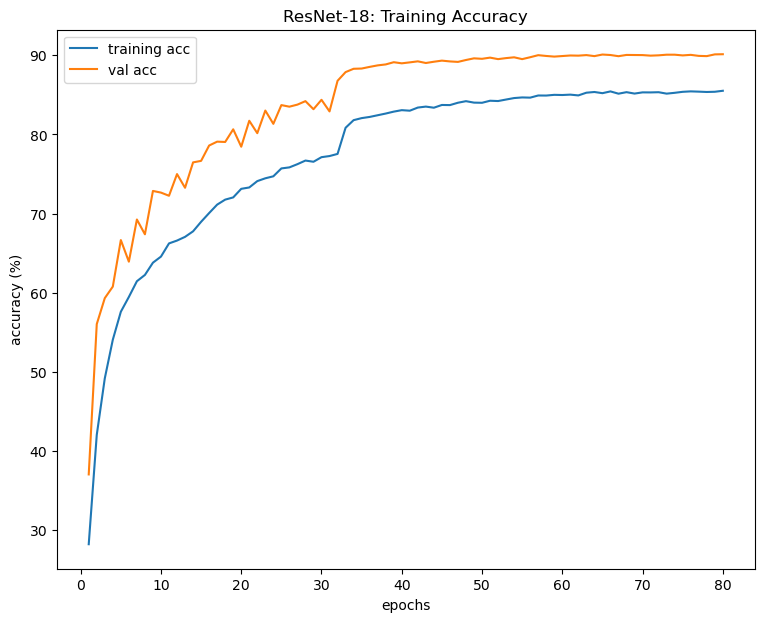

In [31]:
# Visualize ResNet-training-
plt.figure(figsize = (9, 7))
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['acc'] for k in training_history_lr_scheduler.keys()], label = 'training acc')
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['val_acc'] for k in training_history_lr_scheduler.keys()], label = 'val acc')
plt.title("ResNet-18: Training Accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy (%)")
plt.legend(loc = 'best')
plt.show()

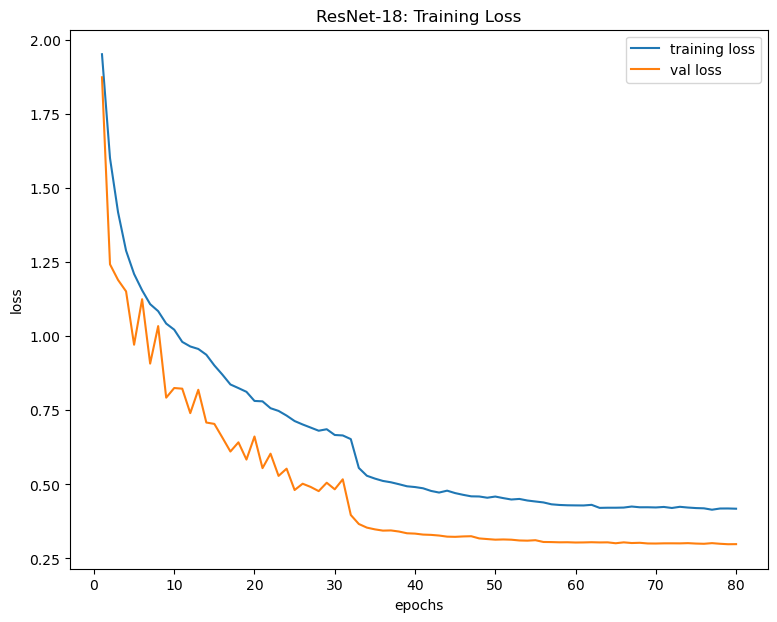

In [32]:
plt.figure(figsize = (9, 7))
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['loss'] for k in training_history_lr_scheduler.keys()], label = 'training loss')
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['val_loss'] for k in training_history_lr_scheduler.keys()], label = 'val loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc = 'best')
plt.title("ResNet-18: Training Loss")
plt.show()

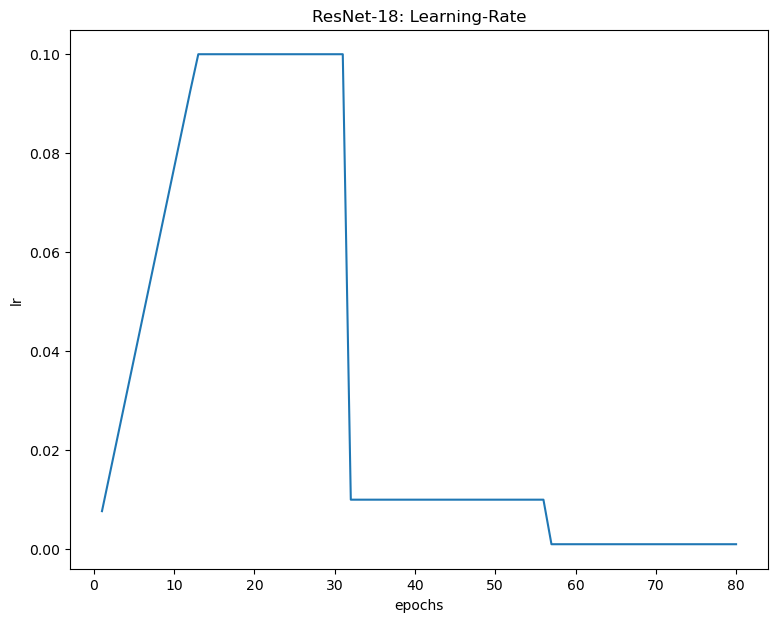

In [33]:
plt.figure(figsize = (9, 7))
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['lr'] for k in training_history_lr_scheduler.keys()])
plt.xlabel("epochs")
plt.ylabel("lr")
plt.title("ResNet-18: Learning-Rate")
plt.show()

In [ ]:
# Initialize and load 'best' trained parameters from above-
best_trained_model = ResNet18().to(device)
best_trained_model.load_state_dict(torch.load('ResNet18_best_valacc_model.pth'))

In [ ]:
# Get validation loss and accuracy-
val_loss, val_acc = test_model_progress(
    model = best_trained_model, test_loader = val_loader,
    test_dataset = val_dataset
)
print(f"ResNet-18 'best' model metrics: val_loss = {val_loss:.4f} & val_acc = {val_acc:.2f}%")